chosen example: 

VAE: clean-gull-718 (Run id: a75dc5ac2d4e443585bc79d76efa02ac)
    beta_start = 0.001

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import h5py
from pathlib import Path
import os
import sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')
from filepaths import filepath_from_ml_artifacts_uri
from analysis.iclr.plotting import settings, fig_size, cb_line_cycler, cb_line_cycler_solid, cb_marker_cycler, savefig
from plot_hdf5_dataset import plot_dataset
from iclr_paper_path import get_paper_path
import matplotlib
settings()
import matplotlib.pyplot as plt

import omegaconf
import torch
from networks.src.load_data import load_dataset_and_config, make_stacked_dataset
from networks.pels_vae_linear.vae_architecture import VAE

from networks.src.kullback_leibler import kullback_leibler, count_populated_dimensions
# from networks.pels_vae_linear.vae_architecture import VAE, loss_function
from analysis.C03_Methods.data.clean_gull_718.artifacts.vae_architecture import VAE, loss_function
from config import train_test_config_class
from networks.src.load_data import load_dataset_and_config, make_stacked_dataset
from networks.src.early_stopping import EarlyStopping
from networks.src.capacity_scheduler import capacity_scheduler as CapacityScheduler
from utils.hydra_mlflow_decorator import log_hydra_to_mlflow

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
os.chdir('../../..')
print(os.getcwd())

print('run this cell only once')

e:\projects\balanced_neural_odes_internal\code\python
run this cell only once


In [4]:
test_vae = True

In [5]:
if test_vae:
    path_dataset_vae = filepath_from_ml_artifacts_uri('mlflow-artifacts:/595842590057669767/a75dc5ac2d4e443585bc79d76efa02ac/artifacts/dataset.hdf5')
    path_model_vae = filepath_from_ml_artifacts_uri('mlflow-artifacts:/595842590057669767/a75dc5ac2d4e443585bc79d76efa02ac/artifacts/model.pt')
else: 
    path_dataset_vae = 'analysis/C03_Methods/data/rare_moth_313/artifacts/dataset.hdf5'
    path_model_vae = 'analysis/C03_Methods/data/rare_moth_313/artifacts/model.pt'

In [6]:
dataset_result = h5py.File(path_dataset_vae, 'r')
print(dataset_result.keys())
kl_test = dataset_result['common_test']['kl_loss_raw'][:]

use_logvar = False
# determine order of dims
kl_test_mean_per_dim = np.mean(kl_test, axis=0)
print(kl_test_mean_per_dim.shape)
ordered_dims = np.argsort(kl_test_mean_per_dim)

<KeysViewHDF5 ['common_test', 'common_validation', 'outputs_names', 'parameters_names', 'states_der_names', 'states_names', 'test', 'time', 'train', 'validation']>
(512,)


In [7]:
if test_vae:
    _path =  filepath_from_ml_artifacts_uri('mlflow-artifacts:/595842590057669767/a75dc5ac2d4e443585bc79d76efa02ac/artifacts/.hydra/config.yaml')
    cfg = omegaconf.OmegaConf.load(_path)
else:
    cfg = omegaconf.OmegaConf.load('analysis/C03_Methods/data/rare_moth_313/artifacts/.hydra/config.yaml')

# load dataset and config
dataset, dataset_config = load_dataset_and_config(cfg)

# make train and test torch tensor datasets
train_dataset = make_stacked_dataset(dataset_config, dataset, 'train')
test_dataset = make_stacked_dataset(dataset_config, dataset, 'test')
validation_dataset = make_stacked_dataset(dataset_config, dataset, 'validation')
common_test_dataset = make_stacked_dataset(dataset_config, dataset, 'common_test')

# initialize data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.nn_model.training.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=cfg.nn_model.training.batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.nn_model.training.batch_size, shuffle=True)
common_test_loader = torch.utils.data.DataLoader(common_test_dataset, batch_size=cfg.nn_model.training.batch_size, shuffle=True)

# initialize model
model = VAE(
    n_states=dataset['train']['states'].shape[1],
    n_outputs=dataset['train']['outputs'].shape[1],
    seq_len=dataset['train']['states'].shape[2],
    parameter_dim=dataset['train']['parameters'].shape[1],
    hidden_dim=cfg.nn_model.network.linear_hidden_dim,
    bottleneck_dim=cfg.nn_model.network.n_latent,
    activation=eval(cfg.nn_model.network.activation),
    n_layers=cfg.nn_model.network.n_linear_layers,
    params_to_decoder=cfg.nn_model.network.params_to_decoder,
)

# load model
model.load_state_dict(torch.load(path_model_vae))
model.eval()
model.to(device)


VAE(
  (timeseries_normalization): NormalizationLayerTimeSeries()
  (Regressor): Regressor(
    (normalization): NormalizationLayer1D(num_features=14)
    (linear): Sequential(
      (0): Linear(in_features=14, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=1024, bias=True)
    )
  )
  (Encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=1685, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=1024, bias=True)
    )
  )
  (Decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_feat

In [8]:
# define one model and loss evaluation
def model_and_loss_evaluation(model, states, outputs, parameters, train=True, n_passes: int = 1, return_model_outputs: bool = False, active_dims = None):
    # active_dims is a torch tensor of shape (n_latent) with boolean values
    x, x_hat, states_hat, outputs_hat, mu, logvar, mu_hat, logvar_hat, normed_values = model(states, outputs, parameters, train=train, predict = False, n_passes=n_passes, active_dims=active_dims)
    
    loss, mse_loss, kl_loss, regressor_loss = loss_function(
                normed_values['x'], normed_values['x_hat'], mu, mu_hat, 
                logvar, logvar_hat, 
                beta=cfg.nn_model.training.beta_start, 
                gamma=cfg.nn_model.training.gamma,
                capacity= None,
    )
    ret_val = {
        'loss': loss,
        'mse_loss': mse_loss,
        'kl_loss': kl_loss,
        'regressor_loss': regressor_loss,
        'populated_dims': count_populated_dimensions(mu, logvar, cfg.nn_model.training.count_populated_dimensions_threshold)[0]
    }
    if return_model_outputs:
        # losses per dim
        _, mse_loss_raw, kl_loss_raw, regressor_loss_raw = loss_function(
                x, x_hat, mu, mu_hat, 
                logvar, logvar_hat, 
                beta=cfg.nn_model.training.beta_start, 
                gamma=cfg.nn_model.training.gamma,
                capacity= None,
                reduce=False
                )   
        model_outputs = {
            'mse_loss_raw': mse_loss_raw,
            'kl_loss_raw': kl_loss_raw,
            'regressor_loss_raw': regressor_loss_raw,
            'states_hat': states_hat,
            'outputs_hat': outputs_hat,
            'mu': mu,
            'logvar': logvar,
            'mu_hat': mu_hat,
            'logvar_hat': logvar_hat,
        }
    if not train:
        # call value.item() for each value in return_value
        ret_val = dict({key: value.item() for key, value in ret_val.items()})
        if return_model_outputs:
            model_outputs = dict({key: value.cpu().detach().numpy() for key, value in model_outputs.items()})
    return ret_val if not return_model_outputs else (ret_val, model_outputs)
    
def get_model_inputs(data_loader: torch.utils.data.DataLoader, data: dict = None):
    if data_loader is None:
        assert data is not None, 'Either data_loader or data must be not None'
    else:
        data = next(iter(data_loader))
    # get data from data loader
    states = data['states'].to(device)
    outputs = data['outputs'].to(device)
    parameters = data['parameters'].to(device)
    return states, outputs, parameters

def test_or_validate_one_epoch(model, _data_loader, n_passes: int = 1, all_batches: bool = False,
                                return_model_outputs: bool = False, active_dims = None):
    
    model.eval()
    # make sure that the data loader is not shuffled by initializing a new data loader
    if all_batches:
        data_loader = torch.utils.data.DataLoader(_data_loader.dataset, batch_size=_data_loader.batch_size, shuffle=False)
    else:
        data_loader = _data_loader
    _ret_vals = []
    _model_outputs = []
    for step, data in enumerate(data_loader):
        states, outputs, parameters = get_model_inputs(data_loader=None, data=data)
        # forward
        with torch.no_grad():
            ret_vals, model_outputs = model_and_loss_evaluation(model, states, outputs, parameters, train=False, n_passes=n_passes, return_model_outputs=True, active_dims=active_dims)
        _ret_vals.append(ret_vals)
        _model_outputs.append(model_outputs)
        if all_batches is False:
            break
    # average over all calls
    if all_batches:
        ret_vals = {}
        for key in _ret_vals[0].keys():
            ret_vals[key] = sum([_ret_val[key] for _ret_val in _ret_vals]) / len(_ret_vals)
    else:
        ret_vals = _ret_vals[0]
    # make one tensor from all model outputs
    if return_model_outputs:
        model_outputs = {key: np.concatenate([_batch_output[key] for _batch_output in _model_outputs], axis=0) for key in _model_outputs[0].keys()}
    return ret_vals if not return_model_outputs else (ret_vals, model_outputs)

def append_context_to_dict_keys(dictionary: dict, context: str):
    return dict({'{}_{}'.format(key, context): value for key, value in dictionary.items()})

ret_vals_active_dims = []
for dim_run in range(kl_test.shape[1]+1):
    # make mask with active dims
    active_dims = torch.zeros(kl_test.shape[1], dtype=torch.bool)
    active_dims[ordered_dims[:dim_run]] = True

    # add model outputs to dataset
    for context, dataloader in zip(['common_test'], [common_test_loader]):
        ret_vals, model_outputs = test_or_validate_one_epoch(model, dataloader, n_passes=cfg.nn_model.training.n_passes_test, all_batches=True, return_model_outputs=True, active_dims=active_dims)
        ret_vals_active_dims.append(ret_vals)

In [9]:
ret_vals_active_dims = pd.DataFrame(ret_vals_active_dims)
if test_vae:
    ret_vals_active_dims.to_csv('analysis/C03_Methods/data/clean_gull_718/artifacts/ret_vals_active_dims.csv')
else:
    ret_vals_active_dims.to_csv('analysis/C03_Methods/data/rare_moth_313/artifacts/ret_vals_active_dims.csv')

In [10]:
print(test_vae)

True


In [11]:
# load data
if test_vae:
    ret_vals_active_dims = pd.read_csv('analysis/C03_Methods/data/clean_gull_718/artifacts/ret_vals_active_dims.csv', index_col=0)
else:
    ret_vals_active_dims = pd.read_csv('analysis/C03_Methods/data/rare_moth_313/artifacts/ret_vals_active_dims.csv', index_col=0)
# reverse order of index
ret_vals_active_dims = ret_vals_active_dims.iloc[::-1]
# initiate index new
ret_vals_active_dims.index = np.arange(ret_vals_active_dims.shape[0])
ret_vals_active_dims.head()

,loss,mse_loss,kl_loss,regressor_loss,populated_dims
0,0.861725,0.846800,13.786067,0.001139,5.0
1,0.367240,0.352316,13.786067,0.001139,5.0
2,0.226983,0.212058,13.786067,0.001139,5.0
3,0.183194,0.168269,13.786067,0.001139,5.0
4,0.138693,0.123768,13.786067,0.001139,5.0


In [12]:
ret_vals_active_dims['mse_loss'][0:5]

0    0.846800
1    0.352316
2    0.212058
3    0.168269
4    0.123768
Name: mse_loss, dtype: float64

finding path that contains "code", then going up one level to find "LaTeX"
e:\projects\balanced_neural_odes_internal\code
e:\projects\balanced_neural_odes_internal
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\VAE\active_dims_sweep_VAE.png
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\VAE\active_dims_sweep_VAE.svg


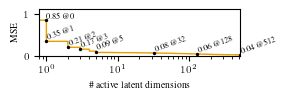

In [26]:
# make plot
fig, ax = plt.subplots(1,1, figsize=fig_size(0.88, n_figs_per_width=2), sharey=True, constrained_layout=True)
ax = [ax]

# plot with reversed order
x = np.arange(0, kl_test.shape[1]+1)
ax[0].step(x, ret_vals_active_dims['mse_loss'], label='MSE loss', color = '#E69F00', lw = 1.0, zorder = 1, where='post')

def add_point(i, ax_i = 0, rotate = 20):
    if i == 0:
        i_x = 1
    else:
        i_x = i
    # put a point at x = 5 with the value of the y axis
    ax[ax_i].scatter(i_x, ret_vals_active_dims['mse_loss'][i], color = 'black', marker = 'o', s = 2)
    # add text
    _text = '{:.2f} @{}'.format(ret_vals_active_dims['mse_loss'][i],i)
    ax[ax_i].text(i_x, ret_vals_active_dims['mse_loss'][i], _text, fontsize = 6, va = 'bottom', ha = 'left', rotation = rotate)

add_point(0, rotate=0)
add_point(1)
add_point(2)
add_point(3)
add_point(5)
# add_point(16)
add_point(32)
# add_point(64)
add_point(128)
# add_point(256)
add_point(512)

# set x axis to log scale
ax[0].set_xscale('log')

# # ax.set_xscale('log')
# ax[1].plot(ret_vals_active_dims['mse_loss'][:20], label='MSE loss', color = 'black', lw = 1.0)
# if test_vae is False:
#     add_point(0, ax_i = 1)
# add_point(5, ax_i = 1)
# add_point(4, ax_i = 1)
# add_point(3, ax_i = 1)
# add_point(2, ax_i = 1)
# add_point(1, ax_i = 1)
# add_point(10, ax_i = 1)
# add_point(17, ax_i = 1)

# ax[1].set_xticks(np.arange(0,20,2))

ax[0].set_ylabel('MSE')
# ax[1].set_ylabel('MSE loss')
ax[0].set_xlabel('\# active latent dimensions')

ax[0].set_ylim([0.0, 1.1])
ax[0].set_xlim([0.8,512])

# save figure
if test_vae:
    savefig(fig, get_paper_path('VAE', 'active_dims_sweep_VAE'))
else:
    savefig(fig, get_paper_path('VAE', 'active_dims_sweep_PELS_VAE'))